# auto_annot_Haber2017_with_Smillie2019_dblabel

In [1]:
import besca as bc
import scanpy as sc
import pandas as pd
import pkg_resources

### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
adata_trains = [bc.datasets.Smillie2019_processed()]

The dataset of interest that should be annotated.

In [3]:
adata_pred = bc.datasets.Haber2017_processed()
adata_orig = bc.datasets.Haber2017_processed()

Give your analysis a name.

In [4]:
analysis_name = 'auto_annot_Haber2017_with_Smillie2019_dblabel' 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [5]:
celltype_train ='dblabel' 
celltype_test = 'dblabel'

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [6]:
method = 'logistic_regression_elastic' # 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [7]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [8]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [9]:
genes_to_use = 'all'

### Prepare all training and the testing set.

In [10]:
# Select epithelial subset from Smillie2019 dataset
epithelial_subset = bc.subset_adata(adata_trains[0], adata_trains[0].obs.celltype_highlevel == 'Epi', raw=False)
adata_trains[0] = epithelial_subset

In [11]:
# Convert mouse symbols (MGI) to human symbols (HGNC)
mousehuman_file = pkg_resources.resource_filename('besca', 'datasets/homologs/MGItoHGNC.csv')
mousehuman=pd.read_csv(mousehuman_file,sep='\t',header='infer', encoding="unicode_escape")
mousehuman.index=mousehuman['MGI']
conversion=pd.Series(data=mousehuman['HGNC'], index=mousehuman.index)

In [12]:
# Convert mouse symbols (MGI) to human symbols (HGNC)
adata_orig.var.rename(columns={'SYMBOL':'MGI'}, inplace=True)
adata_orig.var['SYMBOL'] = adata_orig.var['MGI'].map(lambda x: conversion.get(x, default='') if type(conversion.get(x, default='')) == str else conversion.get(x, default=None).values[0])
adata_orig.var.index = adata_orig.var.SYMBOL
adata_orig.var_names_make_unique()
adata_pred = adata_orig.copy()

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [13]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 278 genes among all datasets
[[0.         0.75137665]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [14]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


max_iter reached after 164 seconds
max_iter reached after 171 seconds
max_iter reached after 175 seconds
max_iter reached after 201 seconds
max_iter reached after 196 seconds
max_iter reached after 203 seconds
max_iter reached after 259 seconds
max_iter reached after 288 seconds
max_iter reached after 292 seconds
max_iter reached after 334 seconds
max_iter reached after 356 seconds
max_iter reached after 362 seconds
max_iter reached after 357 seconds
max_iter reached after 340 seconds
max_iter reached after 326 seconds
max_iter reached after 336 seconds
max_iter reached after 343 seconds
max_iter reached after 343 seconds
max_iter reached after 288 seconds
max_iter reached after 286 seconds
max_iter reached after 282 seconds
max_iter reached after 233 seconds
max_iter reached after 223 seconds
max_iter reached after 228 seconds
max_iter reached after 230 seconds
max_iter reached after 225 seconds
max_iter reached after 236 seconds
max_iter reached after 264 seconds
max_iter reached aft

[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed: 45.1min finished


### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [15]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0.7)

Write out metrics to a report file, create confusion matrices and comparative umap plots

In [16]:
adata_pred.obs

CELL CONDITION  \
0      haber_intestine_donor_M1_Duo.AAACATACAGCGGA   healthy   
1      haber_intestine_donor_M1_Duo.AAACATACCTTACT   healthy   
2      haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA   healthy   
3      haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA   healthy   
4      haber_intestine_donor_M1_Duo.AAACGCTGCGTGAT   healthy   
...                                            ...       ...   
10891   haber_intestine_donor_M2_Il.TTTCAGTGACCAGT   healthy   
10892   haber_intestine_donor_M2_Il.TTTCGAACAGAACA   healthy   
10893   haber_intestine_donor_M2_Il.TTTCTACTGCTCCT   healthy   
10894   haber_intestine_donor_M2_Il.TTTGACTGCGCCTT   healthy   
10895   haber_intestine_donor_M2_Il.TTTGCATGGAGGAC   healthy   

                            sample_type donor region_x  sample  percent_mito  \
0      mouse_small_intestine_epithelial    M1      Duo  Duo_M1      0.001410   
1      mouse_small_intestine_epithelial    M1      Duo  Duo_M1      0.010779   
2      mouse_small_intestine_epithelial    M1      Duo  Duo_M1      0.022508   
3      mouse_small_intestine_epithelial    M1      Duo  Duo_M1      0.015041   
4      mouse_small_intestine_epithelial    M1      Duo  Duo_M1      0.023022   
...                                 ...   ...      ...     ...           ...   
10891  mouse_small_intestine_epithelial    M2       Il   Il_M2      0.008591   
10892  mouse_small_intestine_epithelial    M2       Il   Il_M2      0.007760   
10893  mouse_small_intestine_epithelial    M2       Il   Il_M2      0.006121   
10894  mouse_small_intestine_epithelial    M2       Il   Il_M2      0.007189   
10895  mouse_small_intestine_epithelial    M2       Il   Il_M2      0.009316   

       n_counts  n_genes batch leiden        celltype0  \
0       12768.0     1227   Duo     22  epithelial cell   
1        6583.0     2156   Duo      3  epithelial cell   
2        2799.0     1362   Duo      1  epithelial cell   
3        6048.0     2287   Duo      9  epithelial cell   
4        2780.0     1320   Duo     17  epithelial cell   
...         ...      ...   ...    ...              ...   
10891    5468.0     2037    Il      9  epithelial cell   
10892   10174.0     2884    Il     31  epithelial cell   
10893    9307.0     2856    Il     10  epithelial cell   
10894    4029.0     1277    Il      0  epithelial cell   
10895    8907.0     2277    Il      3  epithelial cell   

                       celltype1                                celltype2  \
0                    paneth cell                              paneth cell   
1                     enterocyte                               enterocyte   
2      epithelial fate stem cell  proliferating epithelial fate stem cell   
3        transit amplifying cell                  transit amplifying cell   
4        transit amplifying cell                  transit amplifying cell   
...                          ...                                      ...   
10891    transit amplifying cell                  transit amplifying cell   
10892        immature enterocyte                      immature enterocyte   
10893       immature goblet cell                     immature goblet cell   
10894                goblet cell                              goblet cell   
10895                 enterocyte                               enterocyte   

                                     celltype3  \
0                                  paneth cell   
1                                   enterocyte   
2      proliferating epithelial fate stem cell   
3                      transit amplifying cell   
4                      transit amplifying cell   
...                                        ...   
10891                  transit amplifying cell   
10892                      immature enterocyte   
10893                     immature goblet cell   
10894                              goblet cell   
10895                               enterocyte   

                                       dblabel         barcode region_y  \
0                 

acc: 0.23
f1: 0.21


... storing 'auto_annot' as categorical


ami: 0.35
ari: 0.16
silhouette dblabel: 0.25
silhouette auto_annot: -0.06
pair confusion matrix:
          0         1
0  87280902  17578048
1   8689738   5163232


... storing 'SYMBOL' as categorical


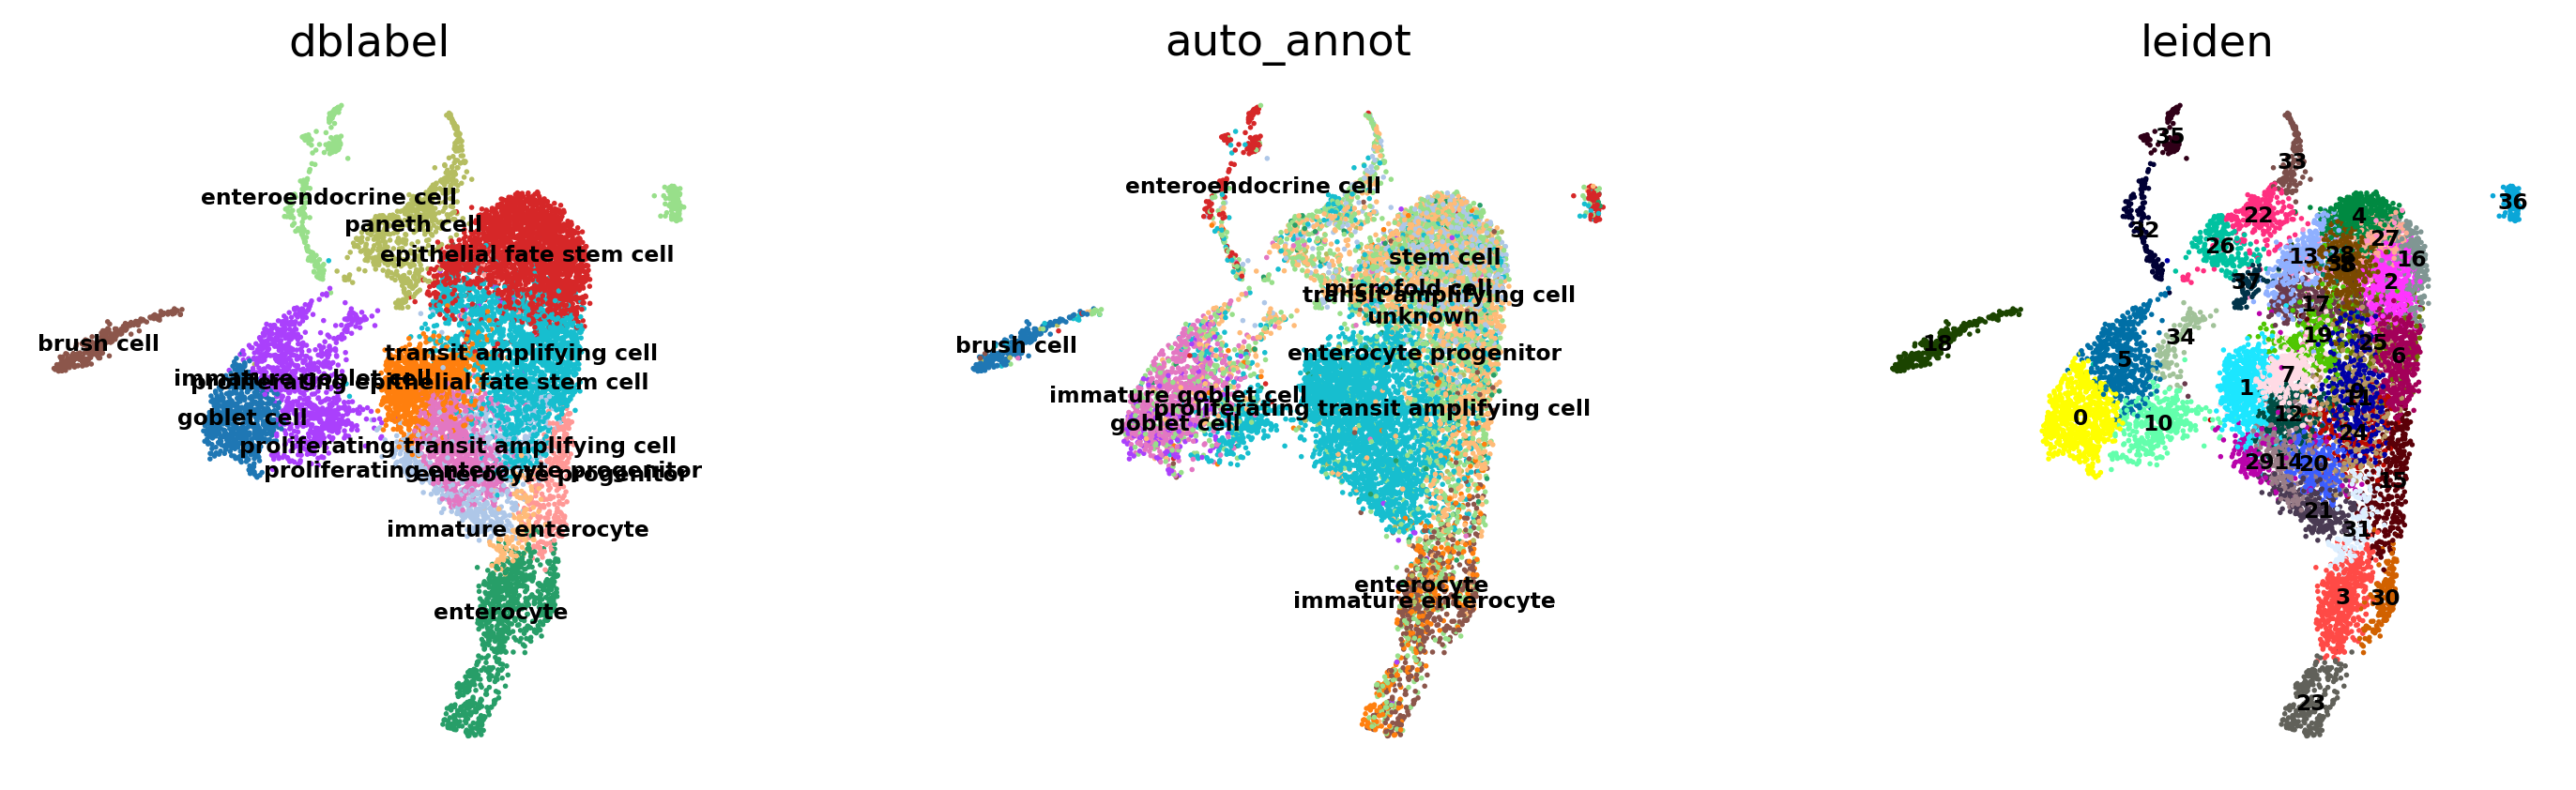

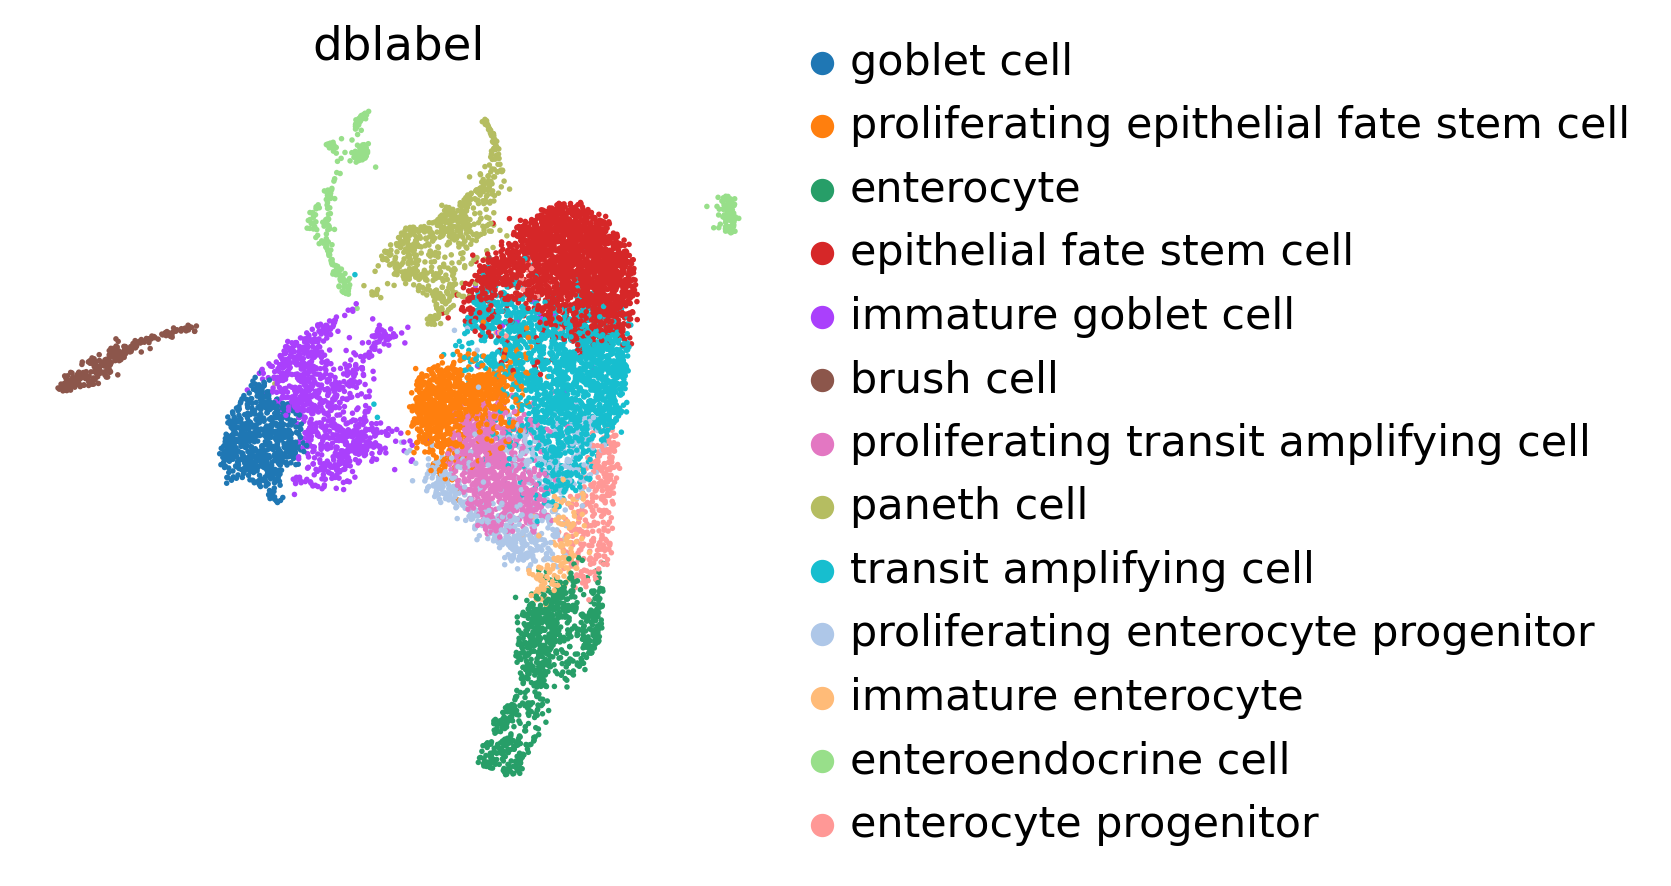

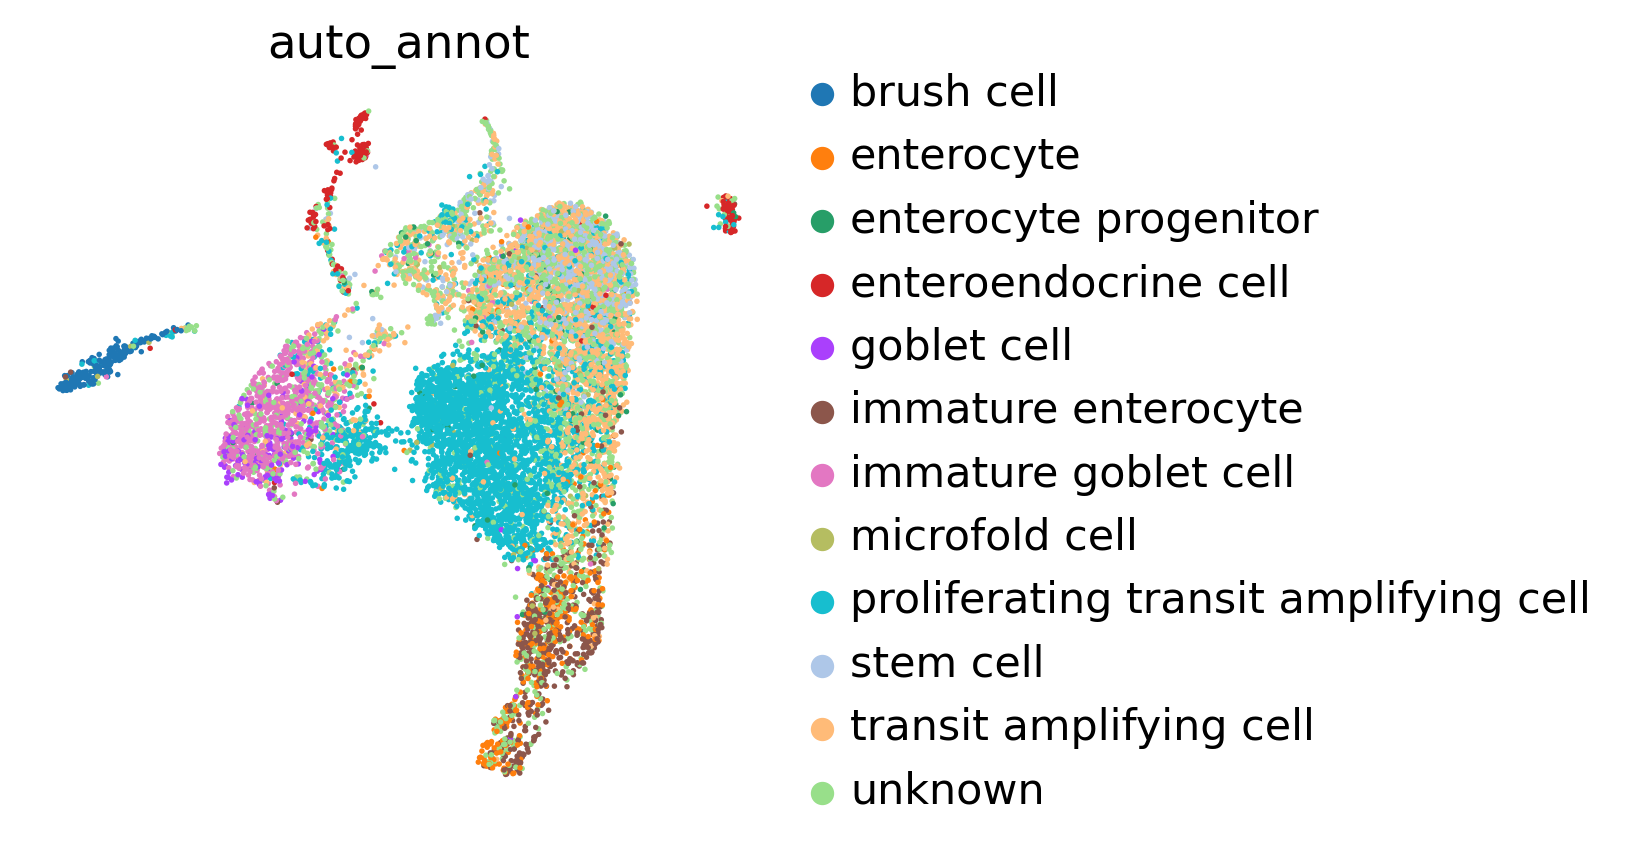

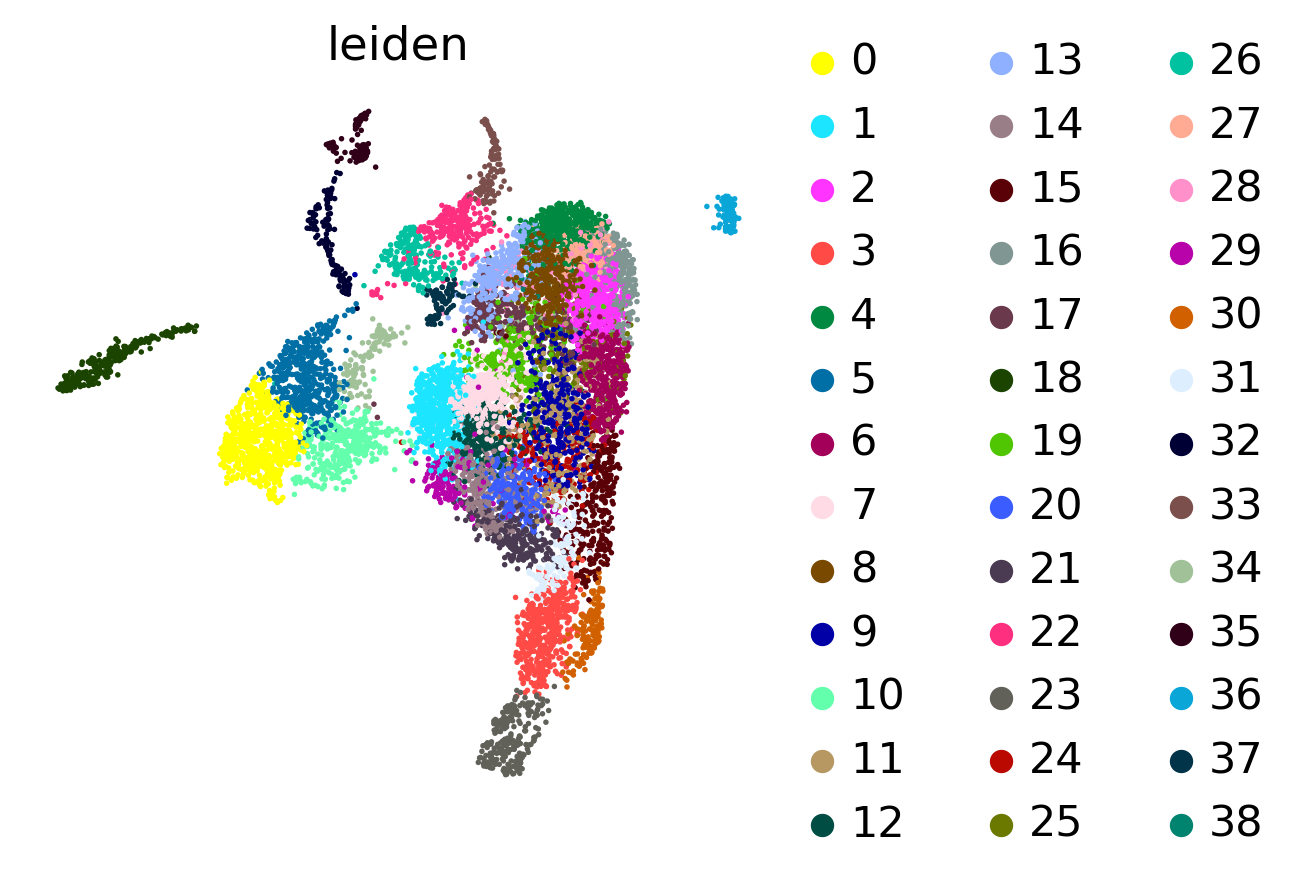

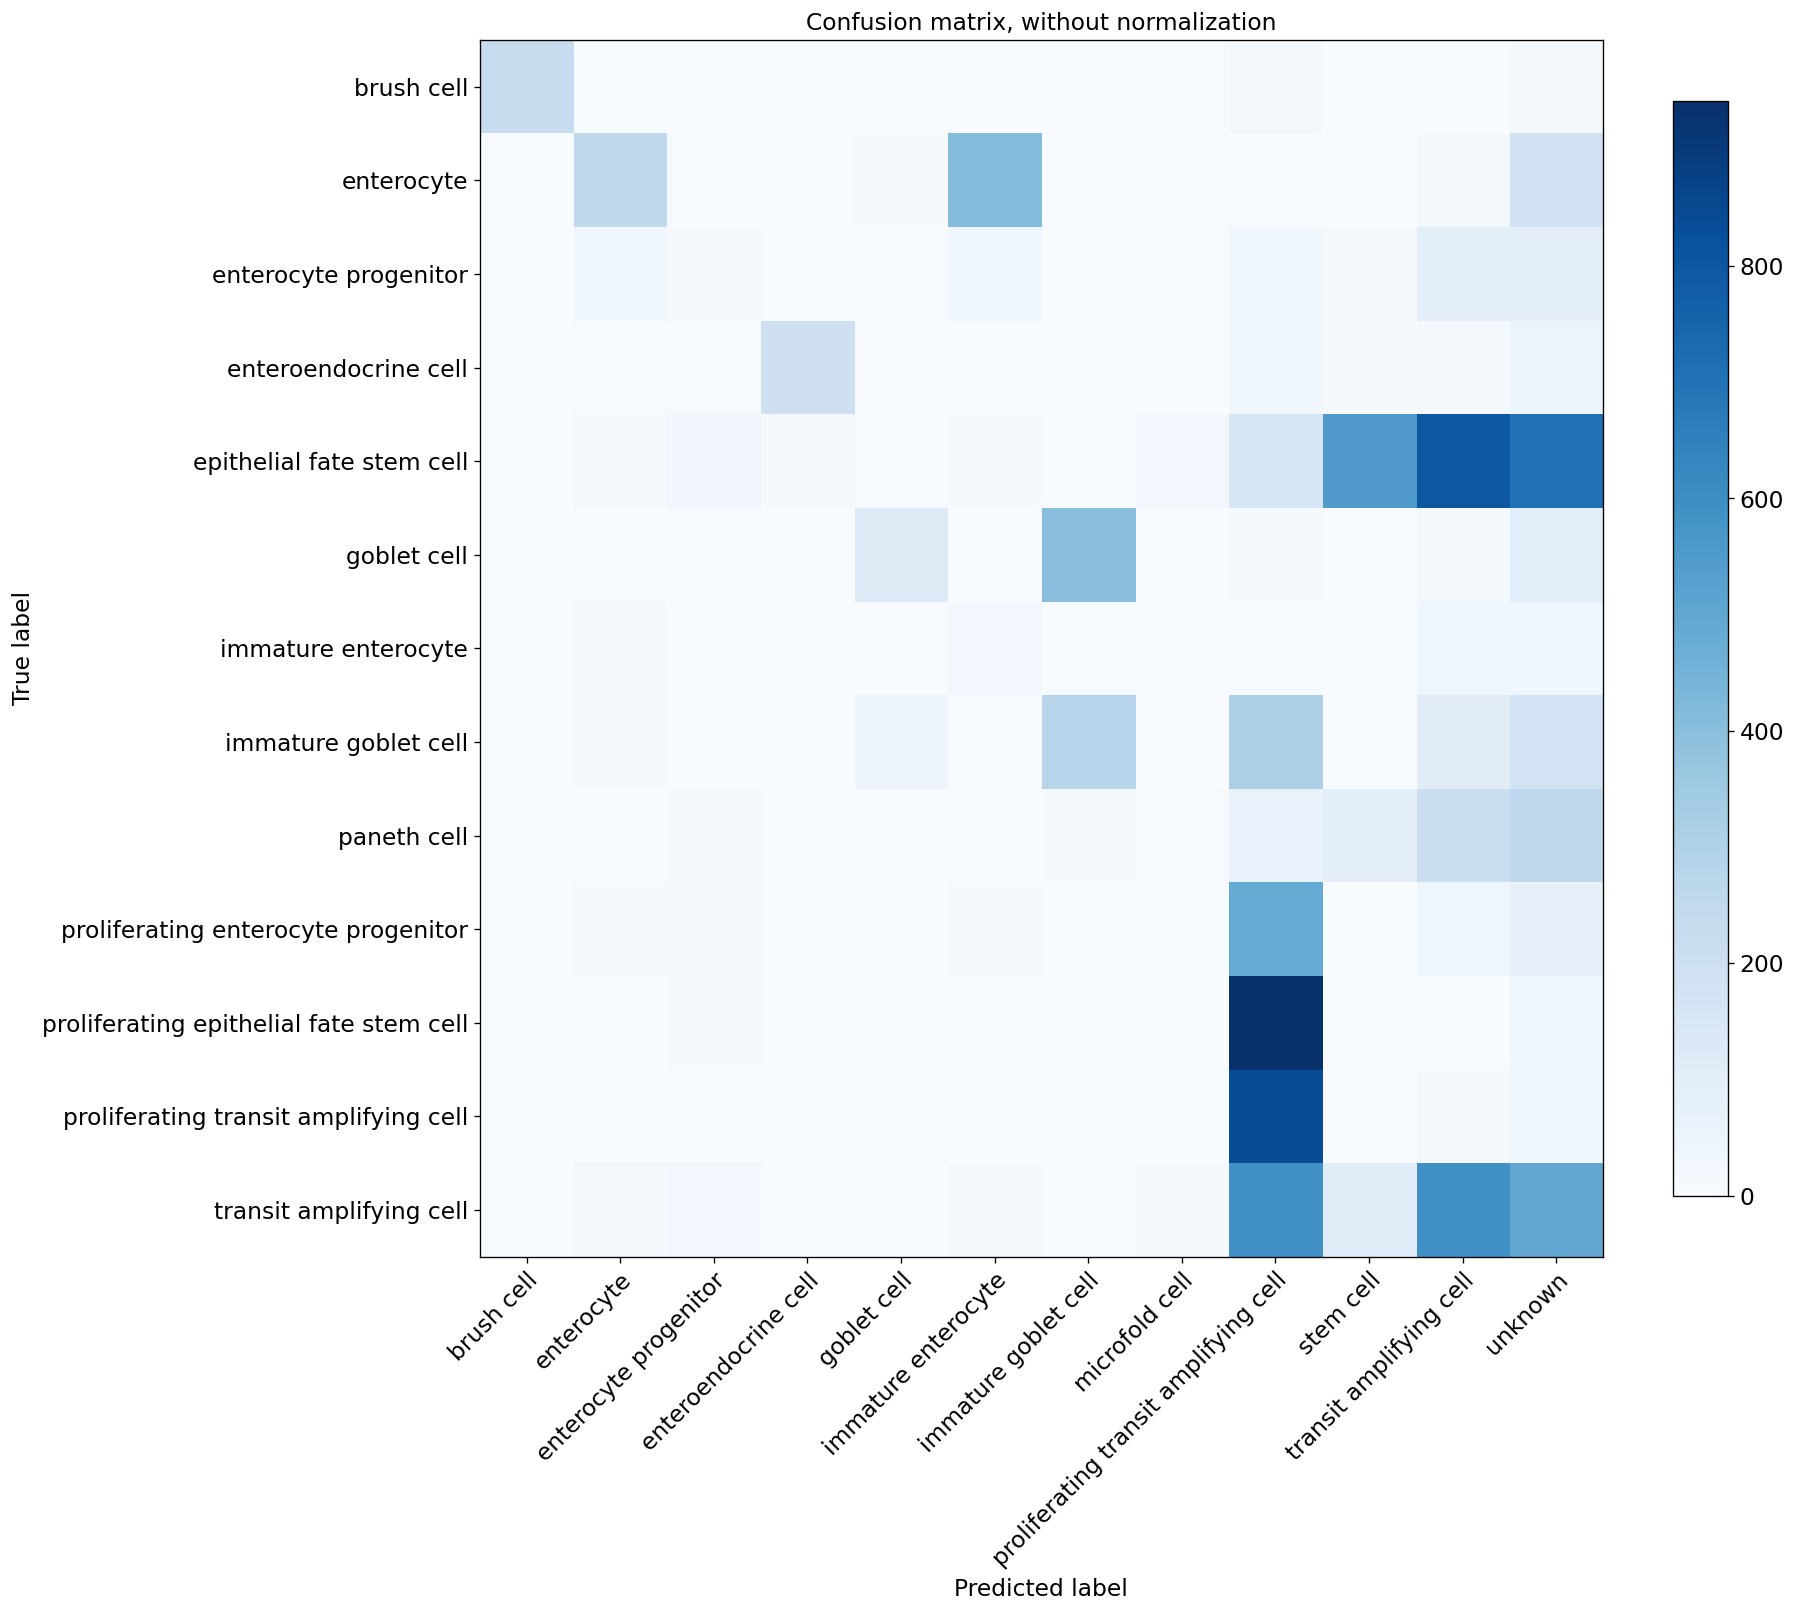

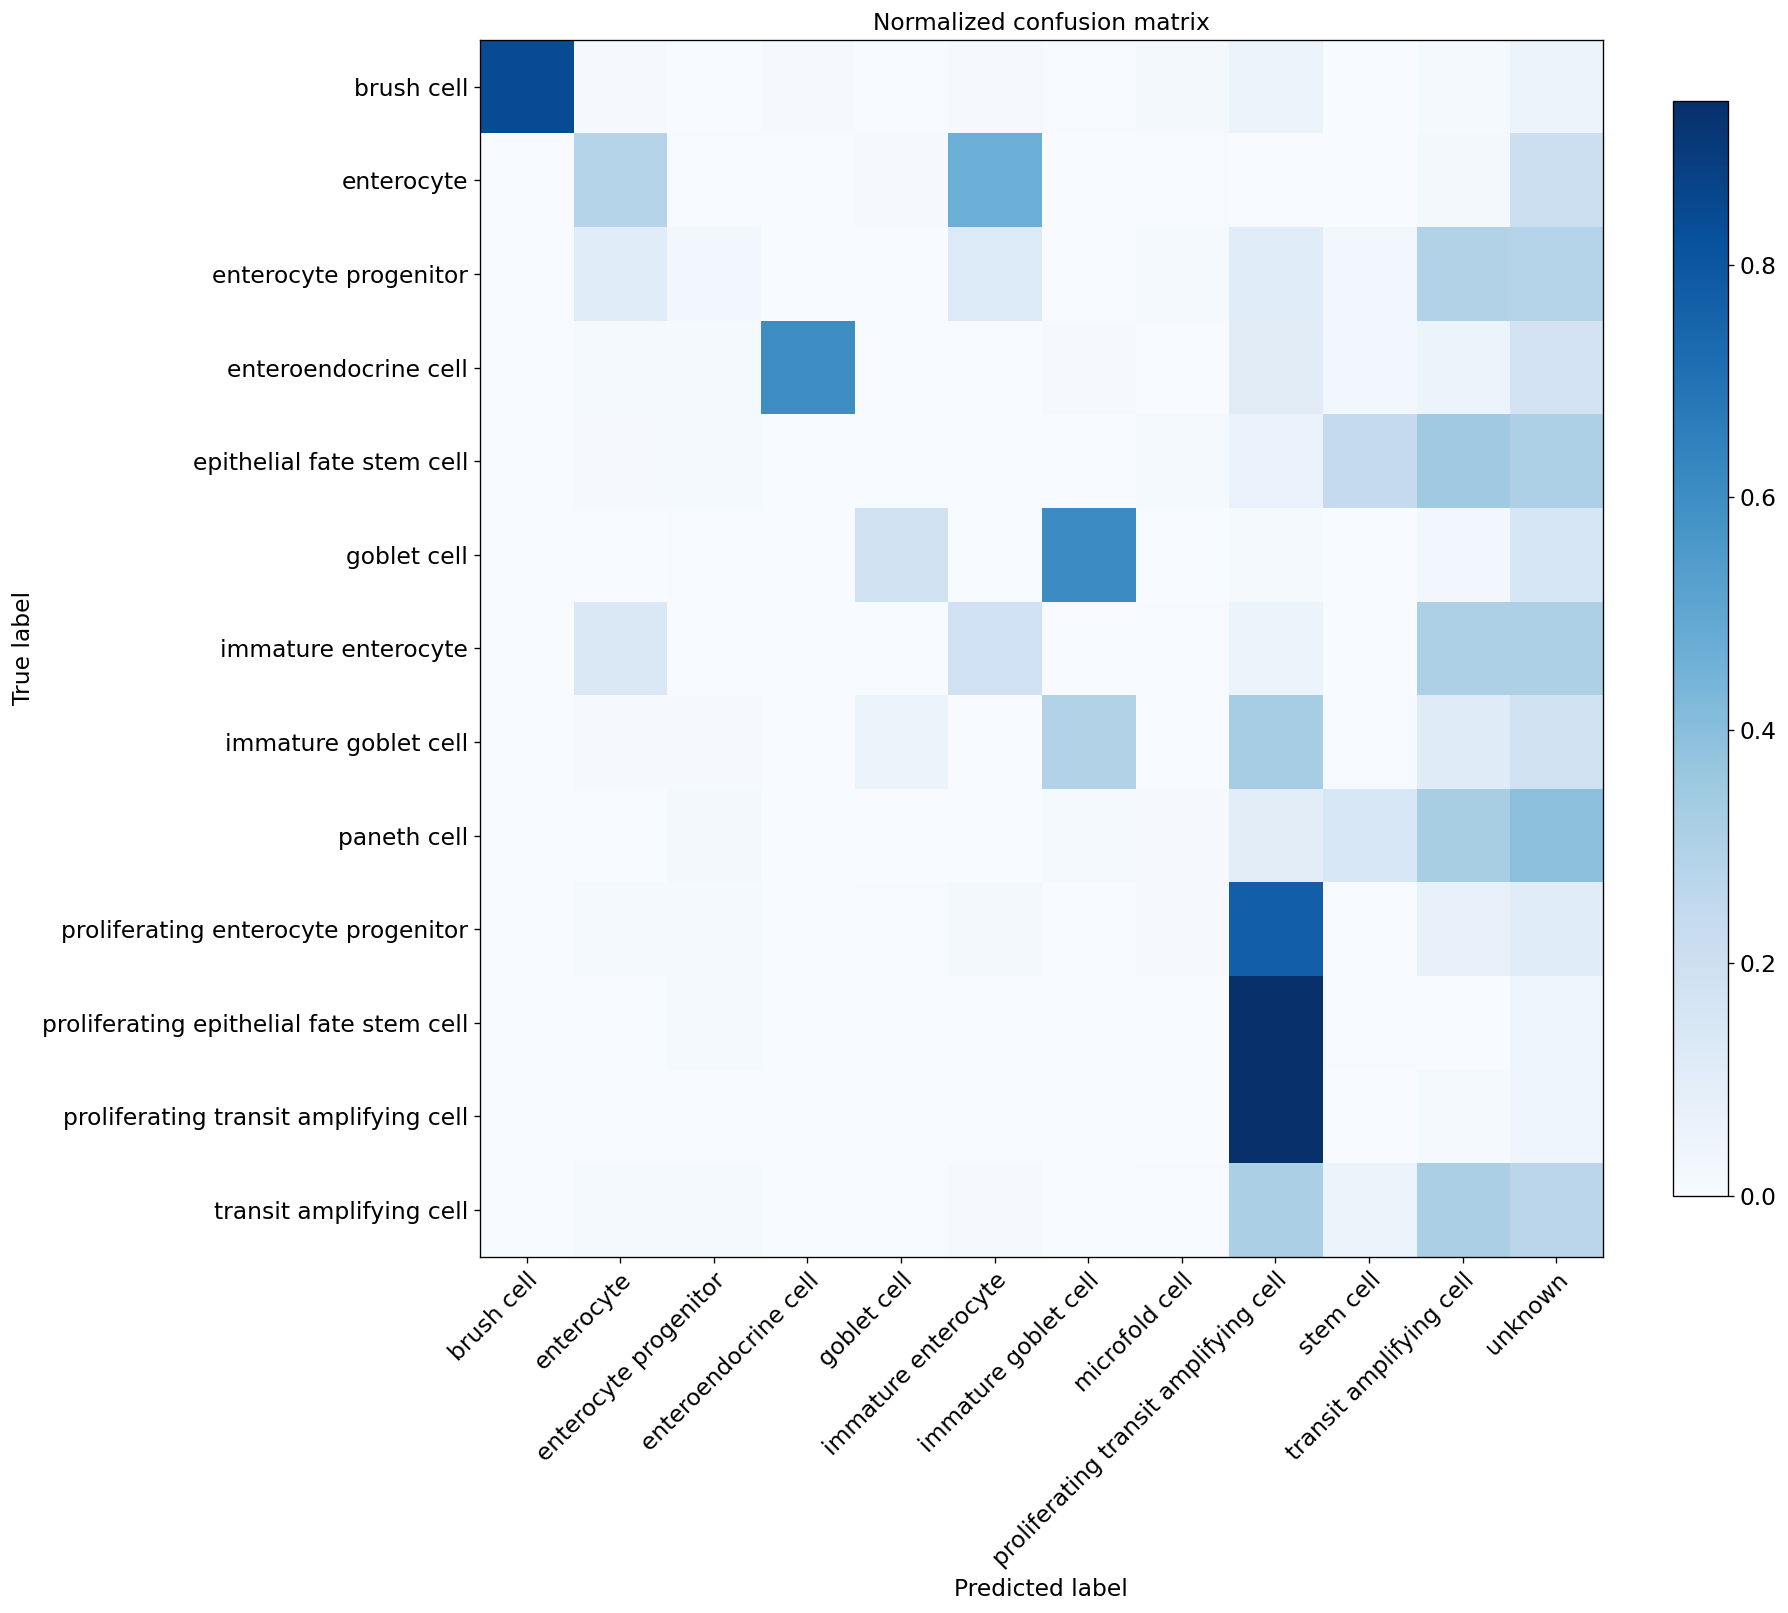

In [17]:
%matplotlib inline

bc.tl.report(
    adata_pred=adata_predicted,
    celltype=celltype_test, 
    method=method, 
    analysis_name=analysis_name,
    train_datasets = adata_trains,
    test_dataset = adata_orig,
    merge = merge,
    name_prediction='auto_annot', 
    name_report='auto_annot', 
    use_raw=use_raw,
    remove_nonshared=True, 
    clustering='leiden', 
    asymmetric_matrix=True, 
    delimiter='\t', 
    verbose=True
)

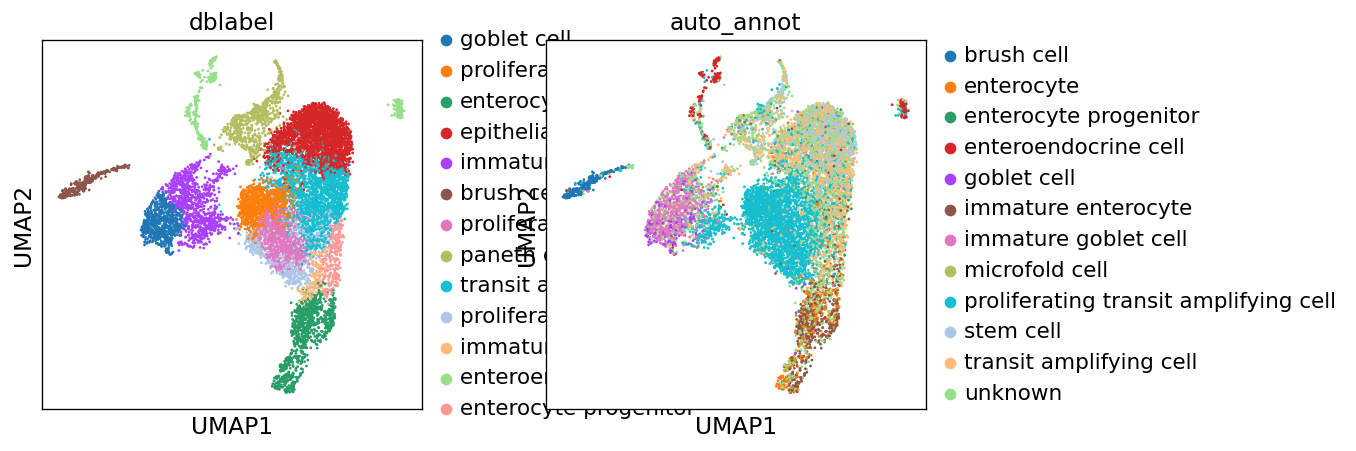

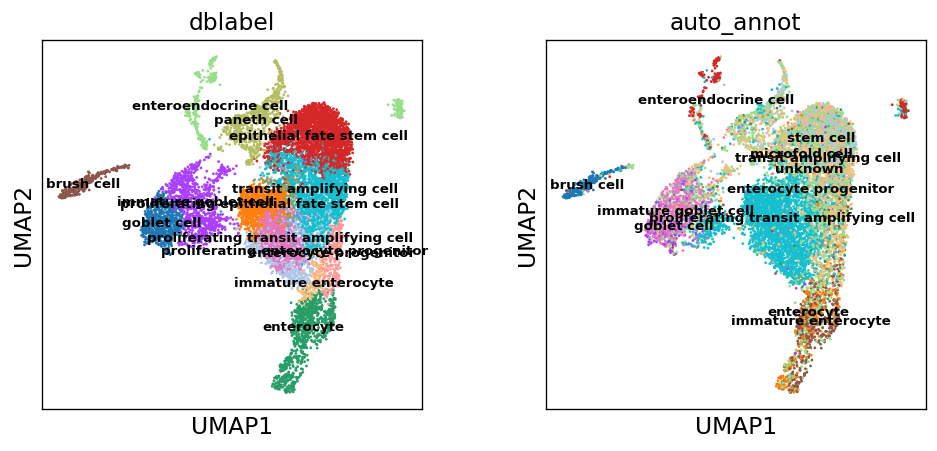

In [18]:
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

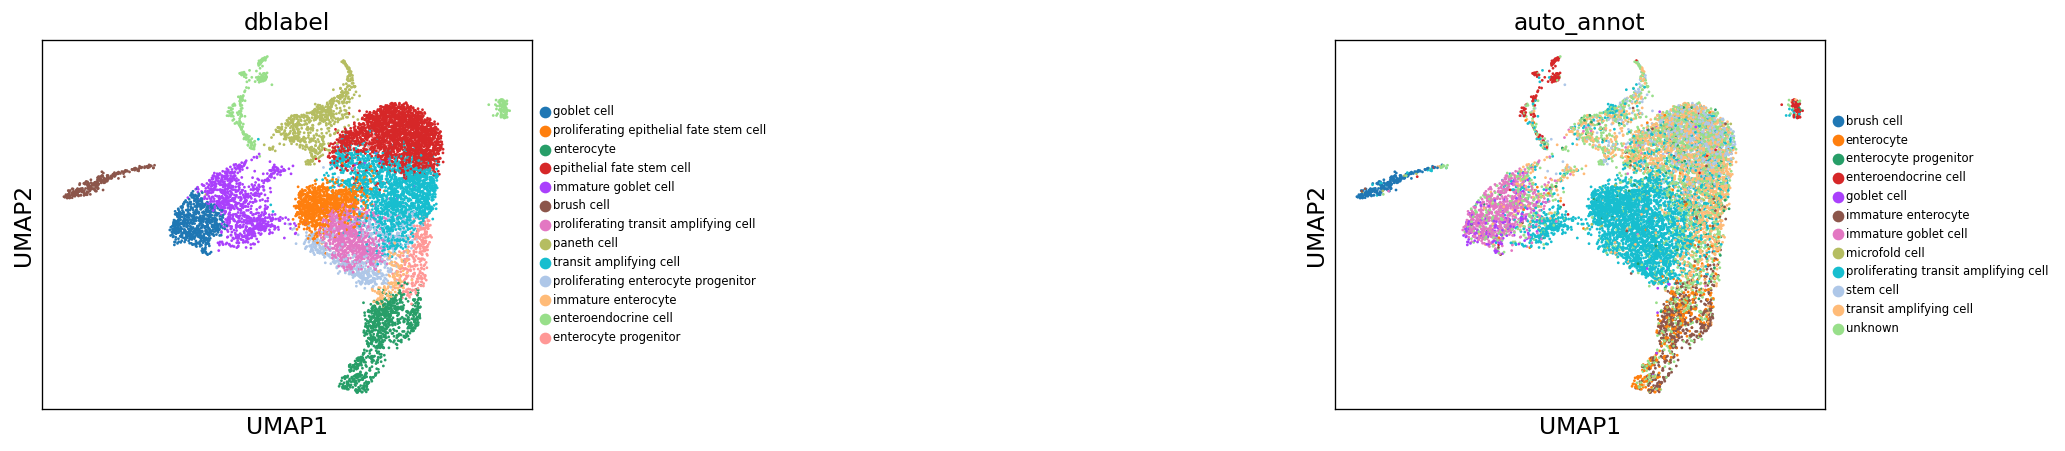

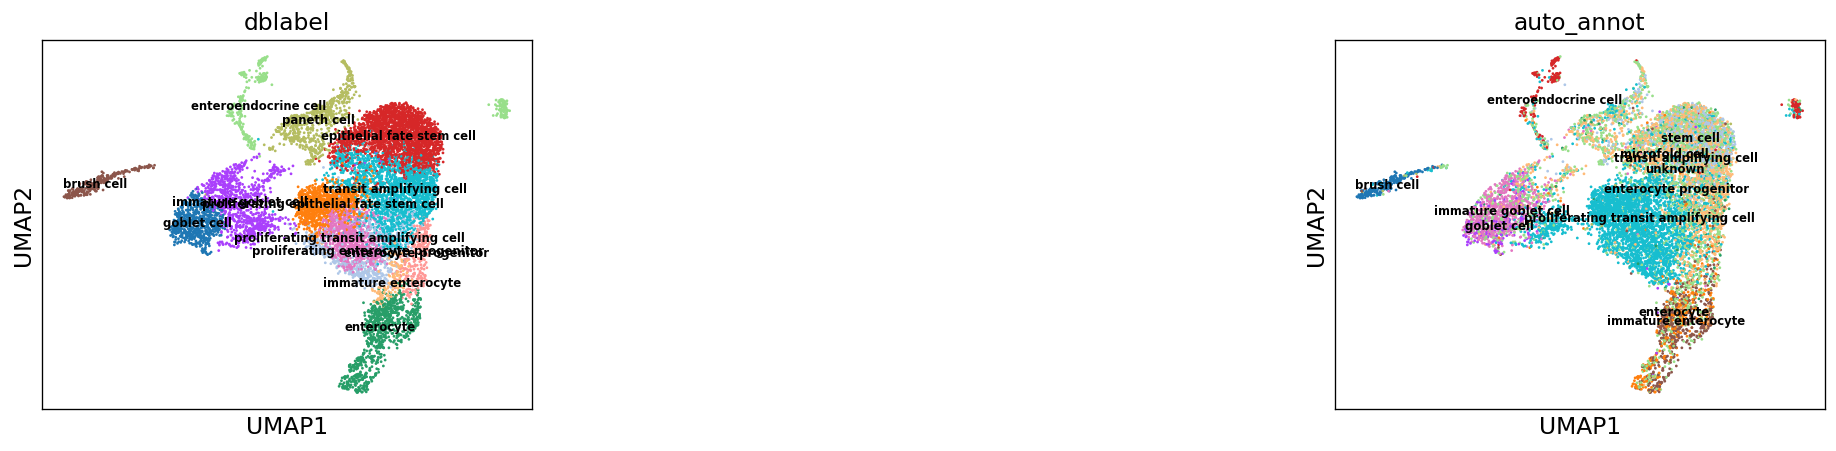

In [19]:
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_fontsize=7, wspace = 1.4, save = '.svg')
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=7, wspace = 1.4, save = '.ondata.svg')

In [20]:
adata_train

View of AnnData object with n_obs × n_vars = 46102 × 278
    obs: 'CELL', 'Cluster', 'Health', 'Location', 'Subject', 'celltype_highlevel', 'nGene', 'nUMI', 'original_name', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'leiden', 'dblabel', 'celltype', 'cluster_celltype', 'Type'
    var: 'SYMBOL', 'ENSEMBL-0', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'ENSEMBL-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1', 'MGI-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1'
    uns: 'Cluster_colors', 'Location_colors', 'Type_colors', 'celltype_highlevel_colors', 'leiden', 'leiden_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'

In [21]:
adata_predicted_wo_unknown = adata_predicted.copy()
adata_predicted_wo_unknown = bc.subset_adata(adata_predicted_wo_unknown, adata_predicted_wo_unknown.obs.auto_annot != 'unknown', raw=False)
bc.pl.riverplot_2categories(adata_predicted_wo_unknown, [celltype_test, 'auto_annot'])

acc: 0.12
f1: 0.12
ami: -0.0
ari: -0.0
silhouette dblabel: 0.25
silhouette random_labeling: -0.03
pair confusion matrix:
          0         1
0  92610210  12248740
1  12248740   1604230


... storing 'random_labeling' as categorical


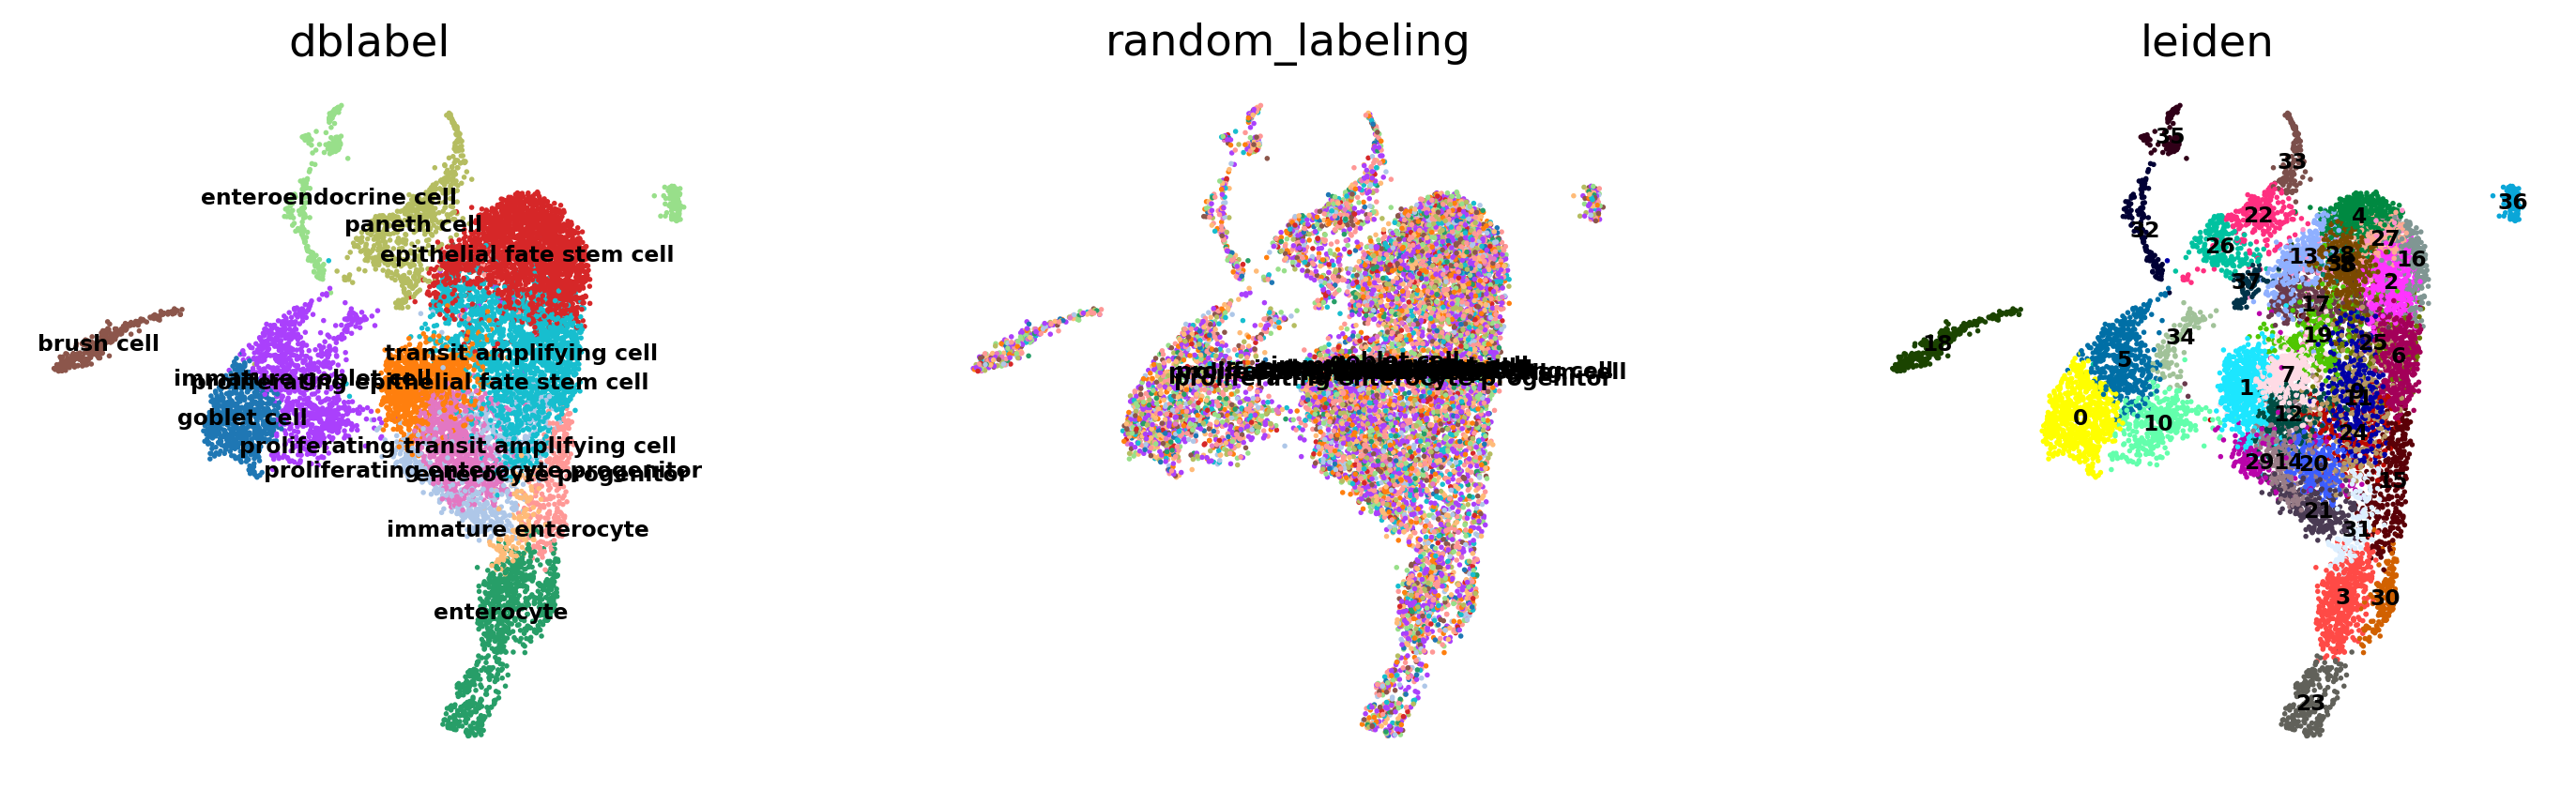

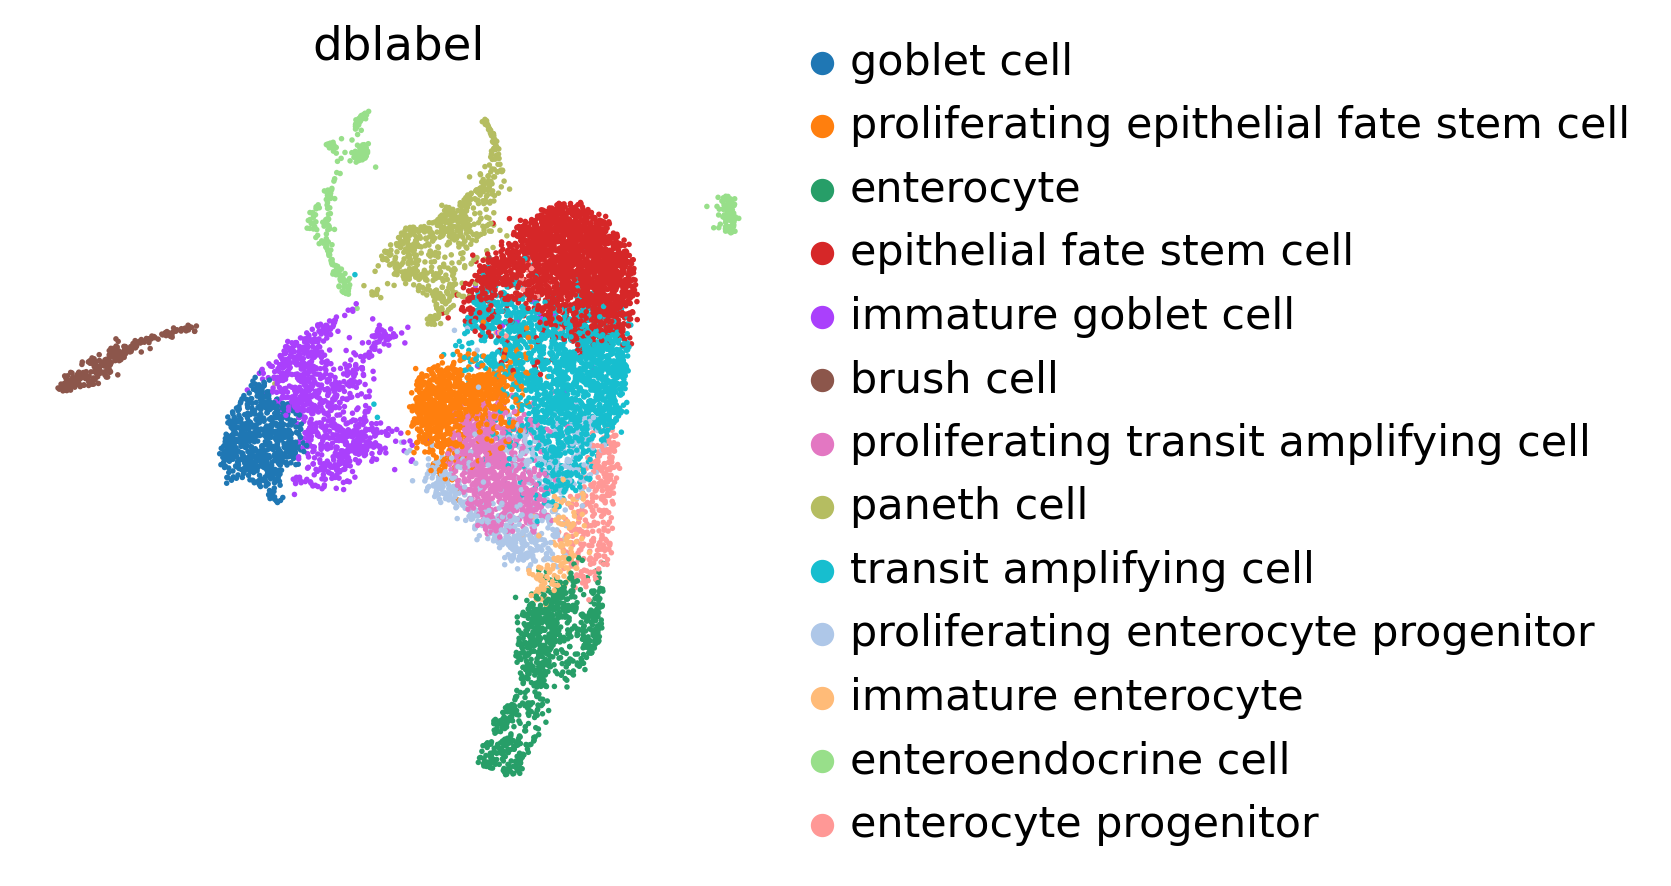

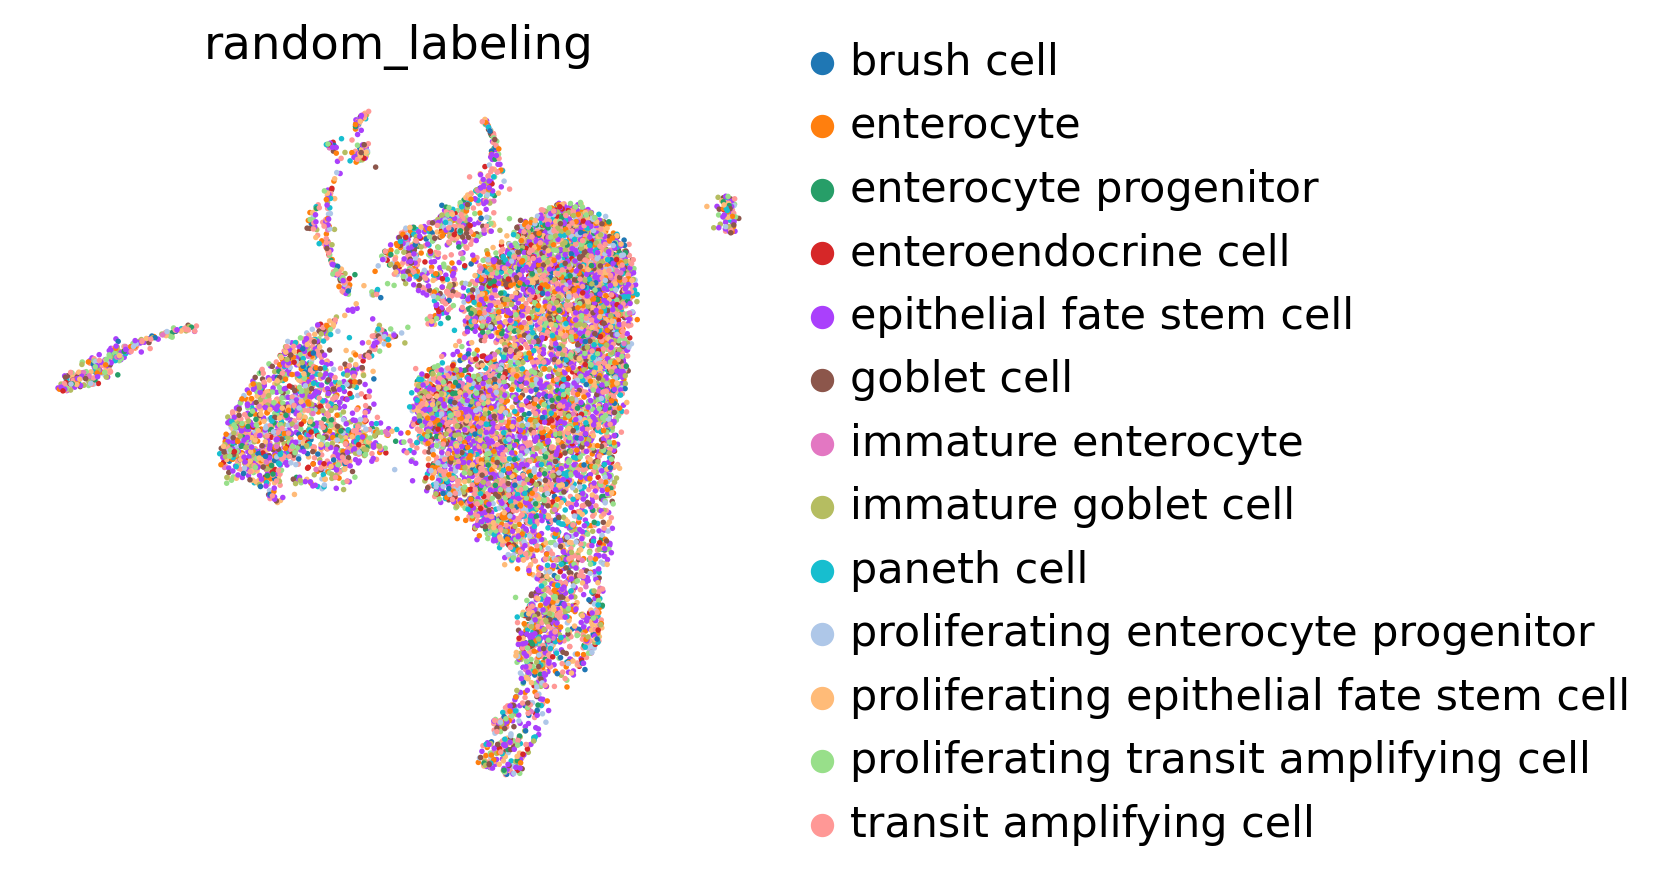

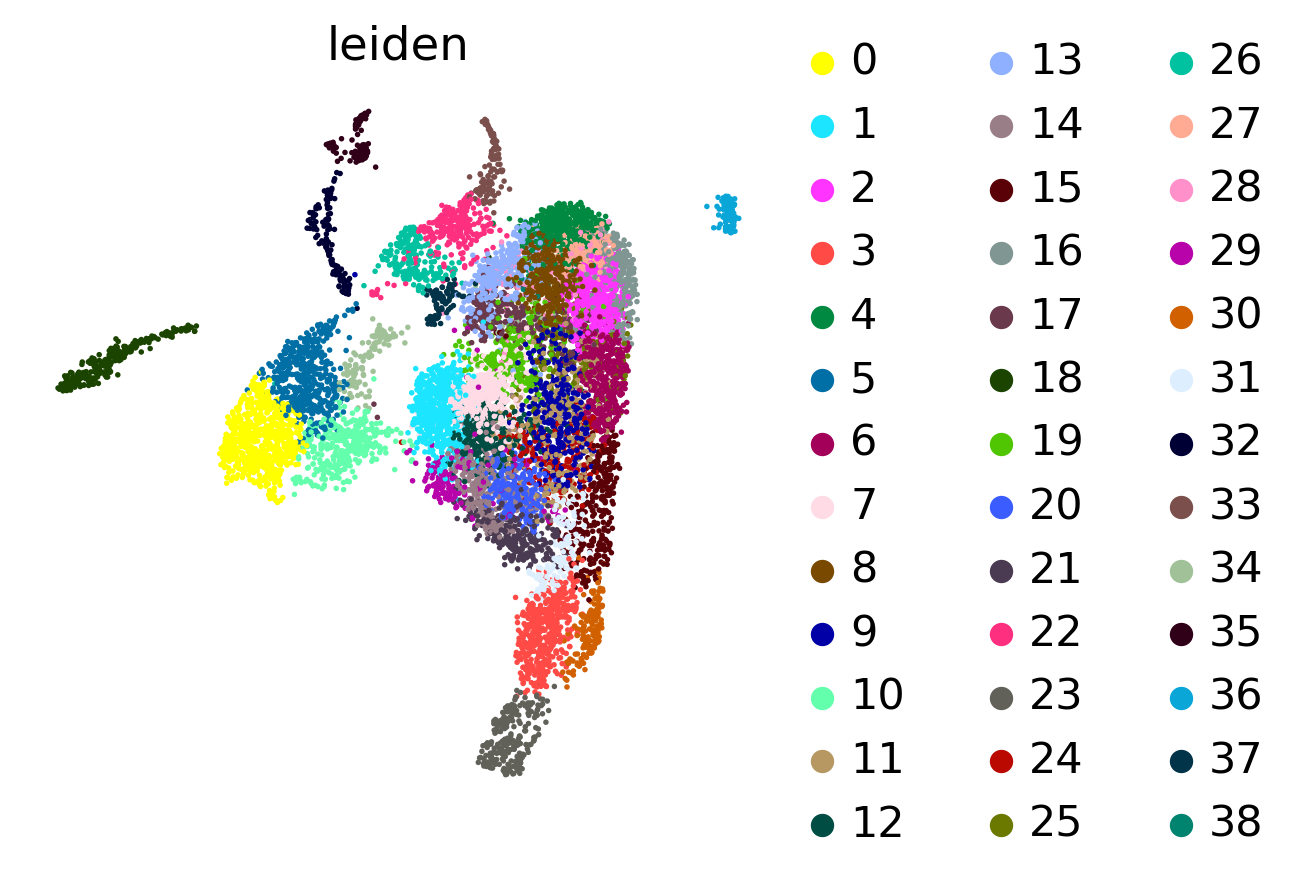

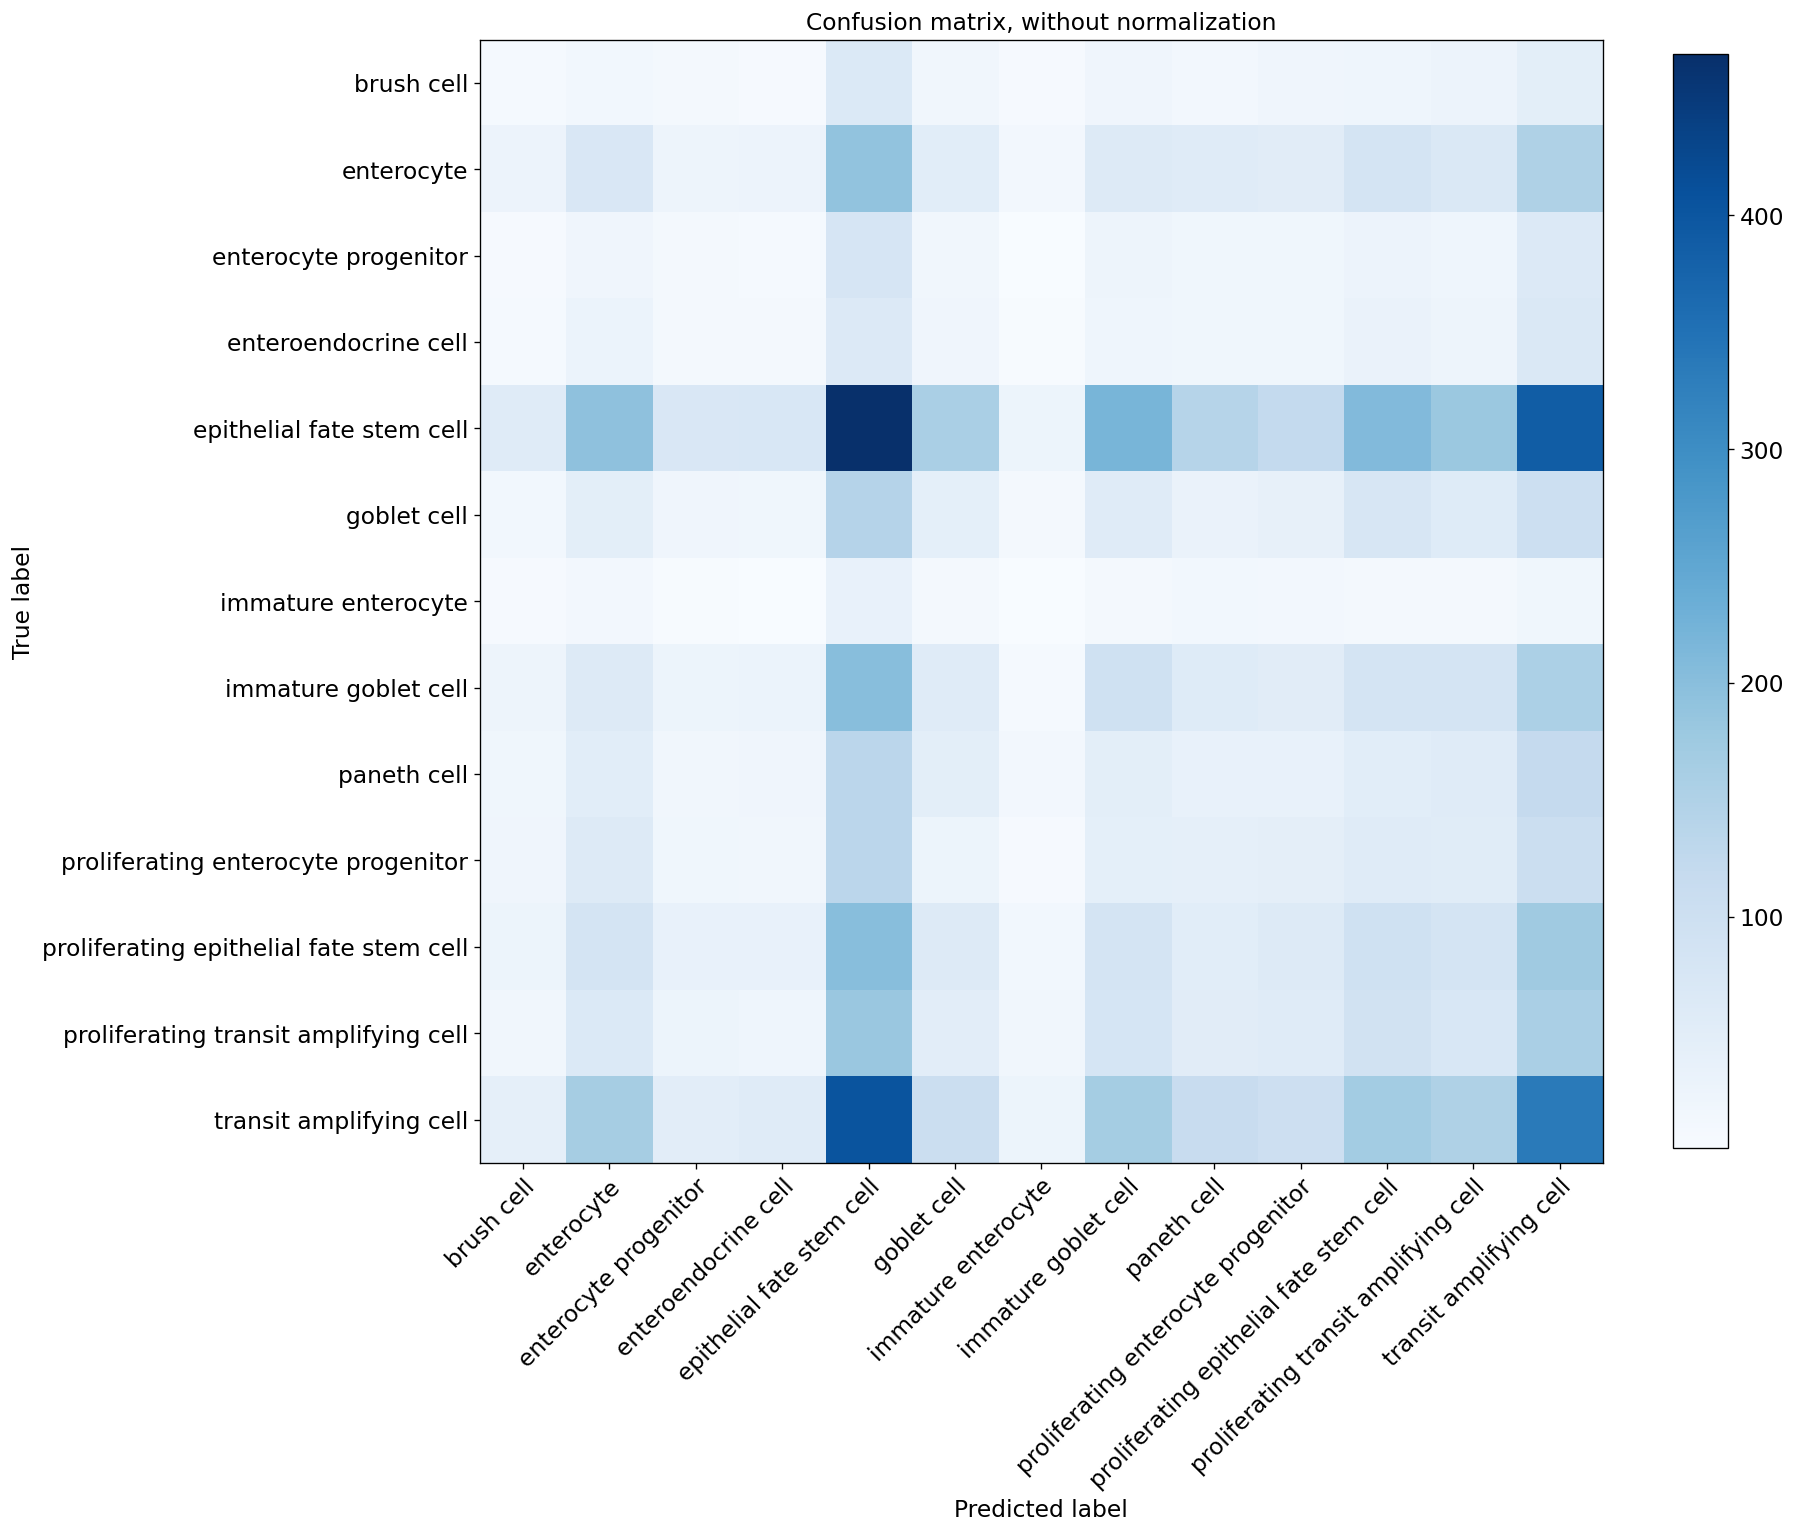

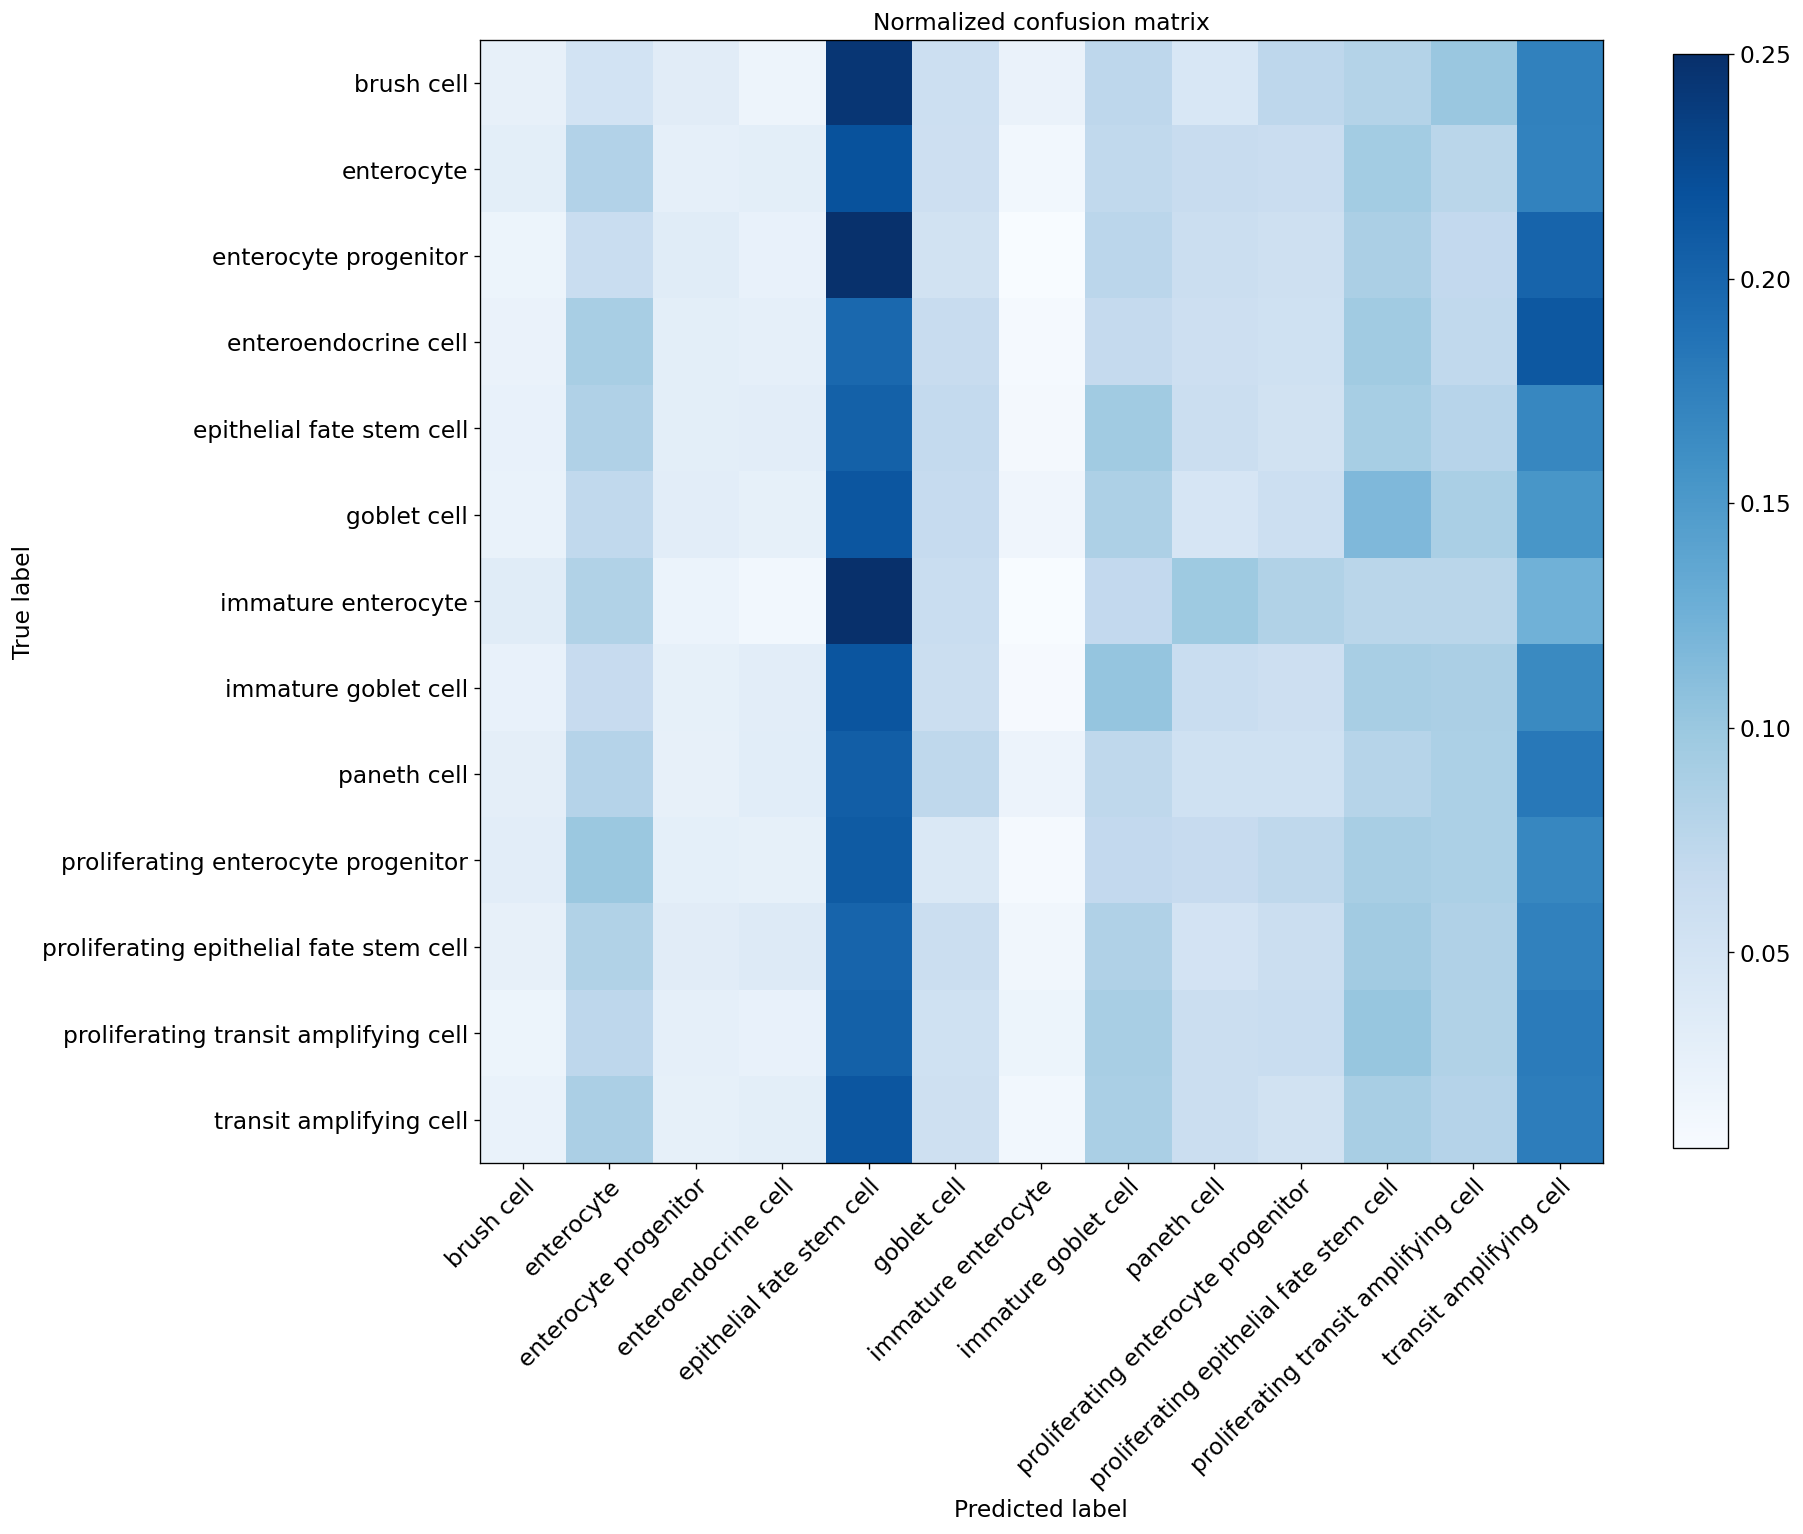

In [23]:
# Compare to random assignment
import random
random.seed(1)
adata_predicted.obs['random_labeling'] = list(adata_predicted.obs[celltype_test].sample(frac=1))

bc.tl.report(
    adata_pred=adata_predicted,
    celltype=celltype_test, 
    method="compare_to_random_" + method, 
    analysis_name=analysis_name,
    train_datasets = adata_trains,
    test_dataset = adata_orig,
    merge = merge,
    name_prediction="random_labeling",
    name_report="compare_to_random_auto_annot", 
    use_raw=use_raw,
    remove_nonshared=False, 
    clustering='leiden', 
    asymmetric_matrix=True, 
    delimiter='\t', 
    verbose=True)

In [24]:
from sinfo import sinfo
sinfo()

-----
anndata             0.7.5
besca               2.4+57.g5ad53b2
pandas              1.2.2
pkg_resources       NA
plotly              4.14.3
scanpy              1.6.1
sinfo               0.3.1
sklearn             0.24.1
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) [GCC 9.3.0]
Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-centos-7.4.1708-Core
24 logical CPU cores, x86_64
-----
Session information updated at 2021-07-18 09:34
